In [1]:
import os

import dill

import matplotlib.pyplot as plt
import torch
import pyro
import copy

import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

import torch
import time

import pandas as pd
from torch.utils.data import DataLoader

from chirho.indexed.ops import IndexSet, gather
import seaborn as sns


import pyro
from pyro.infer import Predictive

from chirho.counterfactual.handlers import MultiWorldCounterfactual
#from cities.modeling.zoning_models.units_causal_model import UnitsCausalModel
from cities.modeling.zoning_models.distance_causal_model import DistanceCausalModel
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data


from pyro.infer.autoguide import AutoDiagonalNormal

from cities.modeling.evaluation import (
    prep_data_for_test,
    test_performance,
)

from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.robust.handlers.predictive import PredictiveModel
from chirho.interventional.handlers import do


smoke_test = "CI" in os.environ

# use when testing model health
smoke_test = True

n_steps = 10 if smoke_test else 1500
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [9]:
start = time.time()

zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))

kwargs = {
    "categorical": [
        "year",
        "month",
        "zone_id",
        "neighborhood_id",
        "ward_id",
        "past_reform",
    ],
    "continuous": {"limit_con", "parcel_area", "distance_to_transit_original", "distance_to_transit"},
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

subset_no_outcome = copy.deepcopy(subset)
subset_no_outcome['outcome'] = None

distance_model = DistanceCausalModel(
    **subset, categorical_levels=zoning_dataset_read.categorical_levels
)



In [10]:

pyro.clear_param_store()

guide_path = os.path.join(root, "data/minneapolis/guides", "distance_model_guide.pkl")

param_path = os.path.join(
    root,  "data/minneapolis/guides", "distance_model_params.pth")

with open(guide_path, "rb") as file:
    guide = dill.load(file)

pyro.get_param_store().load(param_path)

predictive = Predictive(model=distance_model, guide=guide, num_samples=num_samples)


Index(['parcel', 'date', 'neighborhood', 'ward', 'downtown_yn',
       'housing_units', 'car_parking', 'bike_parking', 'parcel_area',
       'university_yn', 'res_parking_elim_2015_yn',
       'res_parking_reduced_2015_yn', 'distance_to_transit', 'census_tract',
       'year', 'year_id', 'month', 'day', 'past_reform', 'limit', 'limit_id',
       'limit_con', 'zone', 'zone_id', 'month_id', 'day_id', 'neighborhood_id',
       'ward_id', 'parcel_id', 'census_tract_id', 'housing_units_std',
       'car_parking_std', 'parcel_area_std', 'distance_to_transit_std'],
      dtype='object')


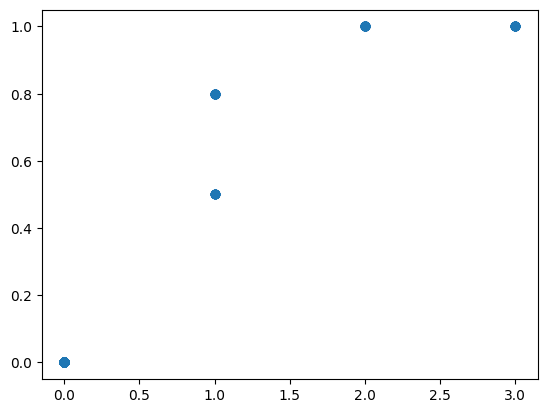

In [33]:
zoning = pd.read_csv(os.path.join(root, "data/minneapolis/processed/zoning_expanded.csv"))
print(zoning.columns)

def intervention(data, radius_blue, limit_blue, radius_yellow, limit_yellow):

    assert radius_blue < radius_yellow

    data = data.copy()

    intervention = zoning['limit_con'].copy()

    downtown = zoning['zone_id'] == 0
    blue = zoning['zone_id'] == 1
    yellow = zoning['zone_id'] == 2

    new_blue =  new_blue = (~downtown) & (zoning['distance_to_transit'] <= radius_blue)
    new_yellow = (~downtown) & (zoning['distance_to_transit'] > radius_blue) & (zoning['distance_to_transit'] <= radius_yellow)
    new_other = (~downtown) & (zoning['distance_to_transit'] > radius_yellow)

    intervention[downtown] = 0.
    intervention[new_blue] = limit_blue
    intervention[new_yellow] = limit_yellow
    intervention[new_other] = 1.
    return intervention

intervention = intervention(zoning, 50, 0.5, 200, 0.8)

plt.scatter(y = intervention, x = zoning['zone_id'])
plt.show()



     

In [14]:

with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit_con": torch.tensor(1.0)}):
        samples = predictive(**subset_no_outcome)